# Benchmark

### Defining Useful helper functions

In [1]:
import menpo.io as mio
from menpo.transform import AlignmentSimilarity
from menpo.shape import PointCloud
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
from menpofit.transform import DifferentiableThinPlateSplines as tps
import numpy as np
from menpofit.error import euclidean_distance_normalised_error
from menpofit.visualize import plot_cumulative_error_distribution
from menpofit.fitter import noisy_shape_from_shape, noisy_target_alignment_transform
from menpo.visualize import print_dynamic
from menpofit.aam import HolisticAAM, PatchAAM
from menpofit.clm import CLM
from menpo.visualize import print_dynamic, print_progress
from menpofit.sdm import RegularizedSDM
from menpofit.aam.base import compute_reference_shape
from menpo.feature import igo, hog, no_op, double_igo as digo, dsift, fast_dsift, hellinger_vector_128_dsift
from menpofit.aam import LucasKanadeAAMFitter

shog = lambda x: hog(x, cell_size=2, block_size=2)
# from menpo.landmark import labeller, svs_face_68, ear_55
%matplotlib inline

/vol/hmi/projects/yuxiang/src/miniconda3/envs/gitdev/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Load Training Images (Ears)

In [2]:
path_to_db = '/vol/atlas/databases/ear/IBUGEARS/CollectionA/'
training_images = []
# load landmarked images
for j,i in enumerate(mio.import_images(path_to_db + '/train*', verbose=True)):
    # convert it to greyscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    i = i.crop_to_landmarks_proportion(0.1)
#     i.landmarks['LABEL'] = i.landmarks['PTS']
#     i.landmarks['LABEL']['outbound'] = range(20) 
#     i.landmarks['LABEL']['inbound'] = range(20, 35)
#     i.landmarks['LABEL']['innerbound'] = range(35, 50)
#     i.landmarks['LABEL']['line5p'] = range(50, 55)
    training_images.append(i)

Found 500 assets, index the returned LazyList to import.


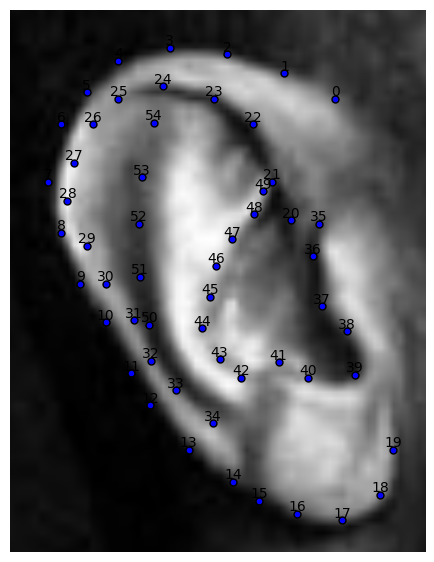

In [3]:
training_images[0].view_landmarks(render_numbering=True)

In [4]:
path_to_db_test = '/vol/atlas/databases/ear/IBUGEARS/CollectionA/test/'
testing_images = []
# load landmarked images
for j,i in enumerate(mio.import_images(path_to_db_test + '*', verbose=True)):
    # convert it to greyscale if needed
    try:
#         cimg = mio.import_pickle('{}/vgg16_features/{}.pkl'.format(i.path.parent, i.path.stem))
#         cimg.landmarks['PTS'] = i.landmarks['PTS'].lms
#         cimg = cimg.crop_to_landmarks_proportion(1)
    #     i.landmarks['LABEL'] = i.landmarks['PTS']
    #     i.landmarks['LABEL']['outbound'] = range(20) 
    #     i.landmarks['LABEL']['inbound'] = range(20, 35)
    #     i.landmarks['LABEL']['innerbound'] = range(35, 50)
    #     i.landmarks['LABEL']['line5p'] = range(50, 55)
    
        if i.n_channels == 3:
            i = i.as_greyscale(mode='luminosity')
        i = i.crop_to_landmarks_proportion(1)
        testing_images.append(i)
    except:
        pass

Found 105 assets, index the returned LazyList to import.


In [5]:
testing_images[-1].path

PosixPath('/vol/atlas/databases/ear/IBUGEARS/CollectionA/test/test_0104.png')

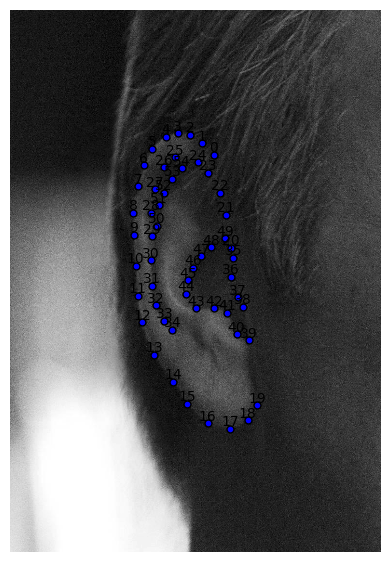

In [6]:
testing_images[-1].view_landmarks(render_numbering=True)

- Computing reference shape                                                     

/vol/hmi/projects/yuxiang/gitdev/menpo/menpo/shape/pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


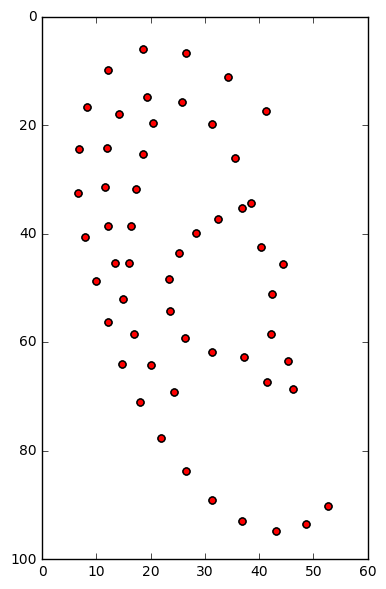

In [7]:
for i in training_images:
    i.landmarks['LMS'] = i.landmarks['PTS'].lms
    
rs = compute_reference_shape(
    [i.landmarks['PTS'].lms for i in training_images],
    100, verbose=True)
    
rs = PointCloud(np.vstack([rs.points, rs.points]))
rs.view()

### Build

In [8]:
def patch_features(x):
    return hellinger_vector_128_dsift(x / 255.0, dtype=np.float32)

In [9]:
n_levels = 3
n_shape = [5,8,13]
scales = (0.25, 0.5, 1.0)
n_appearance = 0.9
max_iters = 50
diagonal=200
f = dsift
patch_shape=[(9, 9),(13, 13),(17, 17)]

### build aam

In [10]:
%%time
# build AAM
dsift_aam = HolisticAAM(training_images,group='PTS',holistic_features=dsift, verbose=True, scales=scales,diagonal=200)
# hog_aam = HolisticAAM(training_images,group='PTS',holistic_features=hog, verbose=True, scales=scales,diagonal=200)
# igo_aam = HolisticAAM(training_images,group='PTS',holistic_features=igo, verbose=True, scales=scales,diagonal=200)
# aam = HolisticAAM(training_images,group='PTS',holistic_features=no_op, verbose=True, scales=scales,diagonal=200)

- Computing reference shape                                                     Computing batch 0
- Normalizing images size: [          ] 0% (1/500) - 00:00:00 remaining         

/vol/hmi/projects/yuxiang/gitdev/menpo/menpo/shape/pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


- Building modelsges size: [==========] 100% (500/500) - done.                  
  - Scale 0: Warping images: [          ] 9% (47/500) - 00:00:01 remaining      ining

/vol/hmi/projects/yuxiang/gitdev/menpofit/menpofit/builder.py:338: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)


  - Scale 0: Doneding appearance model                                          
  - Scale 1: Doneding appearance model                                          
  - Scale 2: Doneding appearance model                                          
                                                              CPU times: user 41.2 s, sys: 1.08 s, total: 42.3 s
Wall time: 30.1 s


### build patch based aam

### build SDM

### build CLM

### export models

## Fit

dcnn_paam = mio.import_pickle('/homes/yz4009/wd/PickleModel/aam-ear-dcnn-3-level.pkl')

#### fit

In [11]:
ear_fitter = dsift_aam_fitter = LucasKanadeAAMFitter(dsift_aam, n_shape=n_shape, n_appearance=n_appearance)

/vol/hmi/projects/yuxiang/gitdev/menpo/menpo/shape/pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


In [12]:
frs = []
for i in print_progress(testing_images[:5]):
    fr = ear_fitter.fit_from_bb(i, i.landmarks['PTS'].lms.bounding_box(), max_iters=max_iters, gt_shape=i.landmarks['PTS'].lms)
    frs.append(fr)

/vol/hmi/projects/yuxiang/gitdev/menpo/menpo/shape/pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


[====================] 100% (5/5) - done.                                       


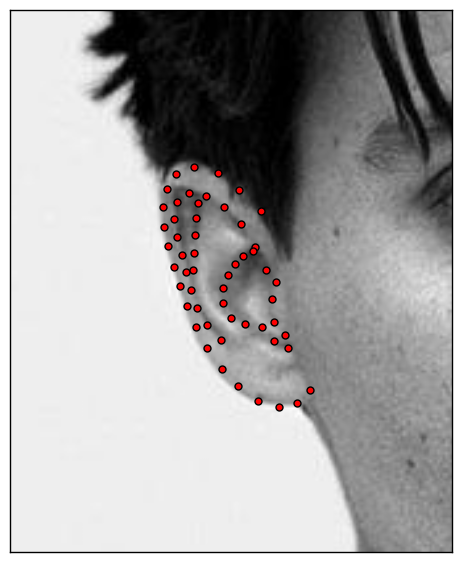

In [13]:
fr.image.view()
fr.final_shape.view()

### Visualise Fitting Results

In [15]:
from menpowidgets import visualize_fitting_results

In [17]:
fitting_results = mio.import_pickle('/homes/yz4009/db/PickleModel/aam-ear-benchmark.pkl', encoding='latin1')

### Plot Results

In [22]:
models = ['SIFT+AAM','HOG+AAM','IGO+AAM','AAM', 'SIFT+PAAM','HOG+PAAM','IGO+PAAM','PAAM', 'SDM', 'CLM', 'DCNN+AAM']
labels = models + ['Init']

In [18]:
from menpowidgets import plot_ced

In [19]:
def error_npp(shape, gt_shape, norm_shape=None):
    r"""
    """
    shape = shape.points[:55]
    gt_shape = gt_shape.points[:55]
    
    def normalizer(shape, gt_shape):
        norm_shape = gt_shape
        return np.max(norm_shape) - np.min(norm_shape)
    return euclidean_distance_normalised_error(shape, gt_shape, normalizer)

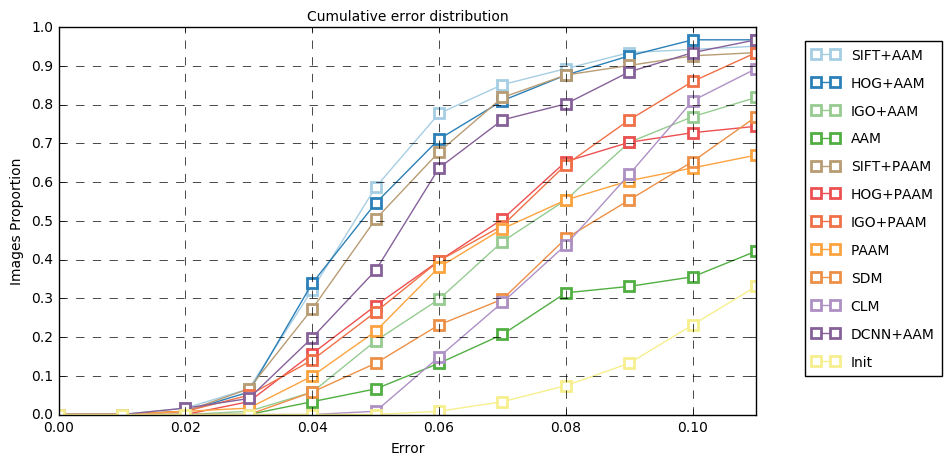

In [23]:
f = plt.figure()
point_error_original = [[fr.final_error(error_npp) for fr in fitting_results[:,j]] for j,_ in enumerate(models)] + [[fr.initial_error() for fr in fitting_results[:,0]]]
plot_ced(point_error_original, legend_entries=labels,error_range=[0,0.22,0.01])

In [27]:
index = 0
print(labels[index])
print ('mean: {}'.format(np.mean(point_error_original[index])))
print ('std: {}'.format(np.std(point_error_original[index])))
print ('median: {}'.format(np.median(point_error_original[index])))
print ('accuracy: {}'.format(np.sum(np.array(point_error_original[index]) <= 0.1) / float(len(point_error_original[index]))))

SIFT+AAM
mean: 0.05223355232874784
std: 0.024647780872555106
median: 0.04532036796250059
accuracy: 0.9421487603305785


In [29]:
# latex generate
# \emph{Method}   & \emph{mean $\pm$ std} & \emph{median} & $\leq 0.10$\\
# \hline\hline
# SIFT+AAM       & 0.0685 $\pm$ 0.0326 & 0.0688 & 90\%\\
for label,err in zip(labels, point_error_original):
    print ("{} & {:0.4f} $\\pm$ {:0.4f}  & {:0.4f} & {:2.0f}\\%\\\\".format(label, np.mean(err), np.std(err), np.median(err),100 * np.sum(np.array(err) <= 0.1) / float(len(err))))

SIFT+AAM & 0.0522 $\pm$ 0.0246  & 0.0453 & 94\%\\
HOG+AAM & 0.0539 $\pm$ 0.0248  & 0.0479 & 97\%\\
IGO+AAM & 0.0786 $\pm$ 0.0295  & 0.0738 & 77\%\\
AAM & 0.2124 $\pm$ 0.2674  & 0.1342 & 36\%\\
SIFT+PAAM & 0.0563 $\pm$ 0.0264  & 0.0493 & 93\%\\
HOG+PAAM & 0.0860 $\pm$ 0.0533  & 0.0700 & 73\%\\
IGO+PAAM & 0.0704 $\pm$ 0.0272  & 0.0709 & 86\%\\
PAAM & 0.1049 $\pm$ 0.0733  & 0.0729 & 64\%\\
SDM & 0.0890 $\pm$ 0.0348  & 0.0862 & 65\%\\
CLM & 0.0862 $\pm$ 0.0296  & 0.0830 & 81\%\\
DCNN+AAM & 0.0599 $\pm$ 0.0272  & 0.0542 & 93\%\\
Init & 0.1276 $\pm$ 0.0332  & 0.1283 & 23\%\\


In [22]:
raise Exception('Stop Here')

Exception: Stop Here

In [81]:
mio.export_pickle(fitting_results, '/homes/yz4009/wd/PickleModel/aam-ear-benchmark.pkl', overwrite=True)

In [ ]:
index = 2
print 'mean: {}'.format(np.mean(point_error_original[index]))
print 'std: {}'.format(np.std(point_error_original[index]))
print 'median: {}'.format(np.median(point_error_original[index]))
print 'accuracy: {}'.format(np.sum(np.array(point_error_original[index]) <= 0.1) / float(len(point_error_original[index])))

In [12]:
fitting_results = np.array(fitting_results).T

In [26]:
point_error = np.array([
    [fr.final_error() for fr in frs] for frs in fitting_results
] + [
    [fr.initial_error() for fr in fitting_results[-1]]
])

In [32]:
zip(labels,point_error[:,60])

[('SIFT+AAM', 0.068756222107714204),
 ('HOG+AAM', 0.054678766710484758),
 ('IGO+AAM', 0.05610154511466614),
 ('AAM', 0.11526889533342854),
 ('SIFT+PAAM', 0.089063921684426117),
 ('HOG+PAAM', 0.051474274842586057),
 ('IGO+PAAM', 0.072218183809070011),
 ('PAAM', 0.24661780405908063),
 ('SDM', 0.075732682014084951),
 ('Init', 0.072889292142914161)]

In [31]:
point_error[:,60]

array([ 0.06875622,  0.05467877,  0.05610155,  0.1152689 ,  0.08906392,
        0.05147427,  0.07221818,  0.2466178 ,  0.07573268,  0.07288929])

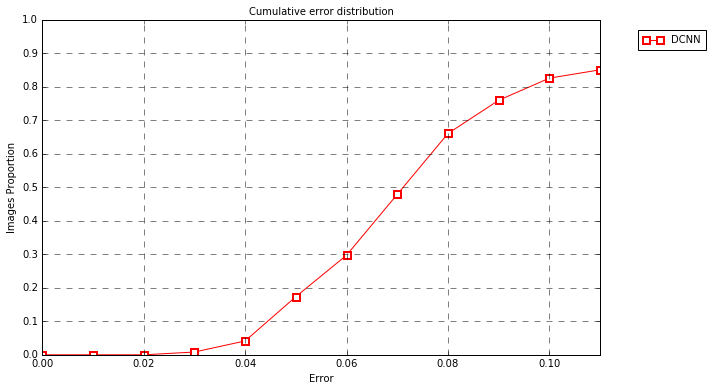

In [73]:
point_error_original = [[fr.final_error() for fr in frs]]
plot_ced(point_error_original, legend_entries=['DCNN'],error_range=[0,0.22,0.01])